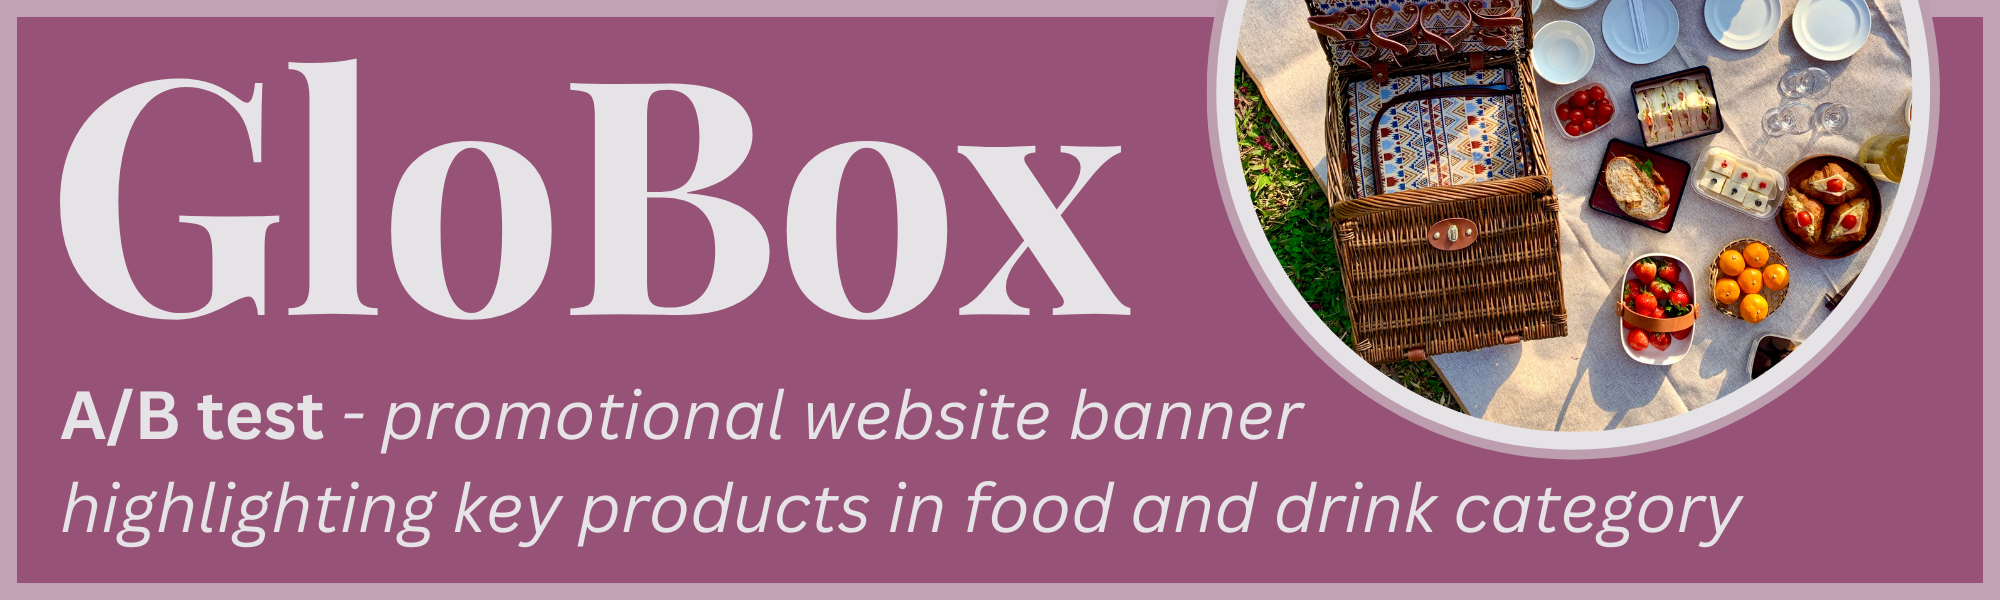



# Project Overview

This project analyzes the results of an A/B test after which we present data-driven recommendations based on our findings.



# Table of contents

- [Project Logistics](#project-background) 
- [Project Background](#project-background) 
- [Data preparation](#data-preparation) 
- [Experiment Design](#experiment-design)
- [Python Functions](#python-functions) 
- [Hypothesis Test: Average Spent Per User](#hypothesis-test-average-spent-per-user) 
- [Hypothesis Test: User Conversion Rate](#hypothesis-test-user-conversion-rate)
- [Results]() 



# Project Logistics

* **Part 1:** Review inferential statistics and create analysis plan.

* **Part 2:** Analyze the A/B test results to determine whether or not the experiments where successfull

* **Part 3:** Record a presentation of the A/B test results and create a written report. 



# Project Background 

The e-commerce company Glowbox specializes in sourcing unique and high-quality prodects from around the world. 

The company is primarily known amongst its customer base for boutique fashion items and high-end decor products. However, their food and drink offerings have grown tremendously in the last few months, and the company wants to bring awareness to this product category to increase revenue.

The Growth team decided to run an A/B test that highlights key products in the food and drink category as a banner at the top of the website. 

> An A/B test is an experimentation technique used by businesses to compare two versions of a webpage, advertisement, or product feature to determine which one performs better. By randomly assigning customers or users to either the A or B version, the business can determine which version is more effective at achieving a particular goal.


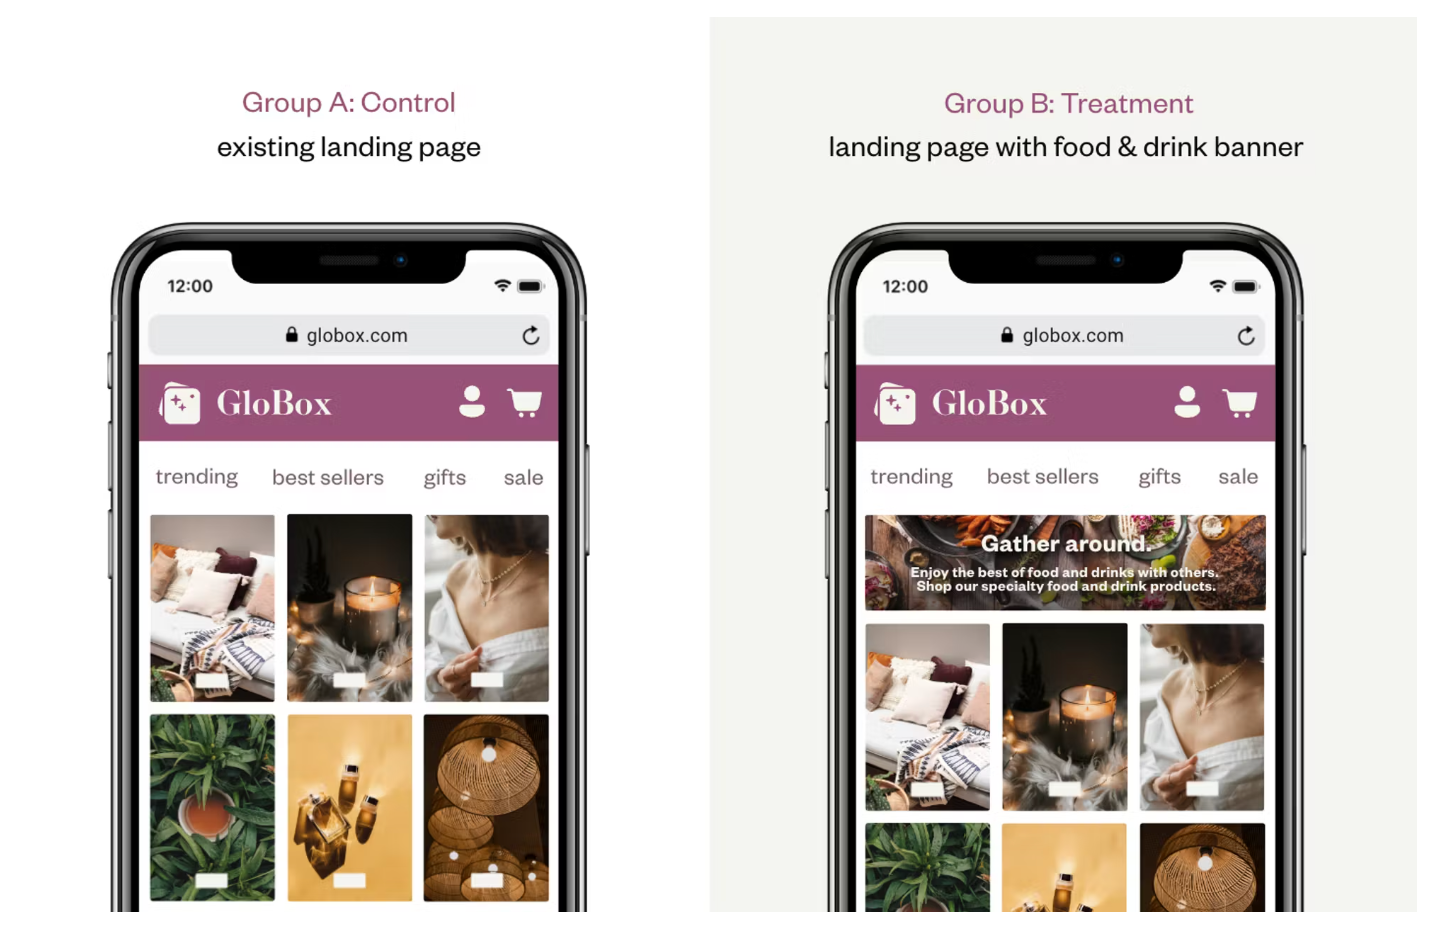

In [88]:



from IPython.display import Image
Image(filename='gloxbox_banner.png', width=700)


# Data Preparation



GloBox stores its data in a relational database, the tables can be seen below: 

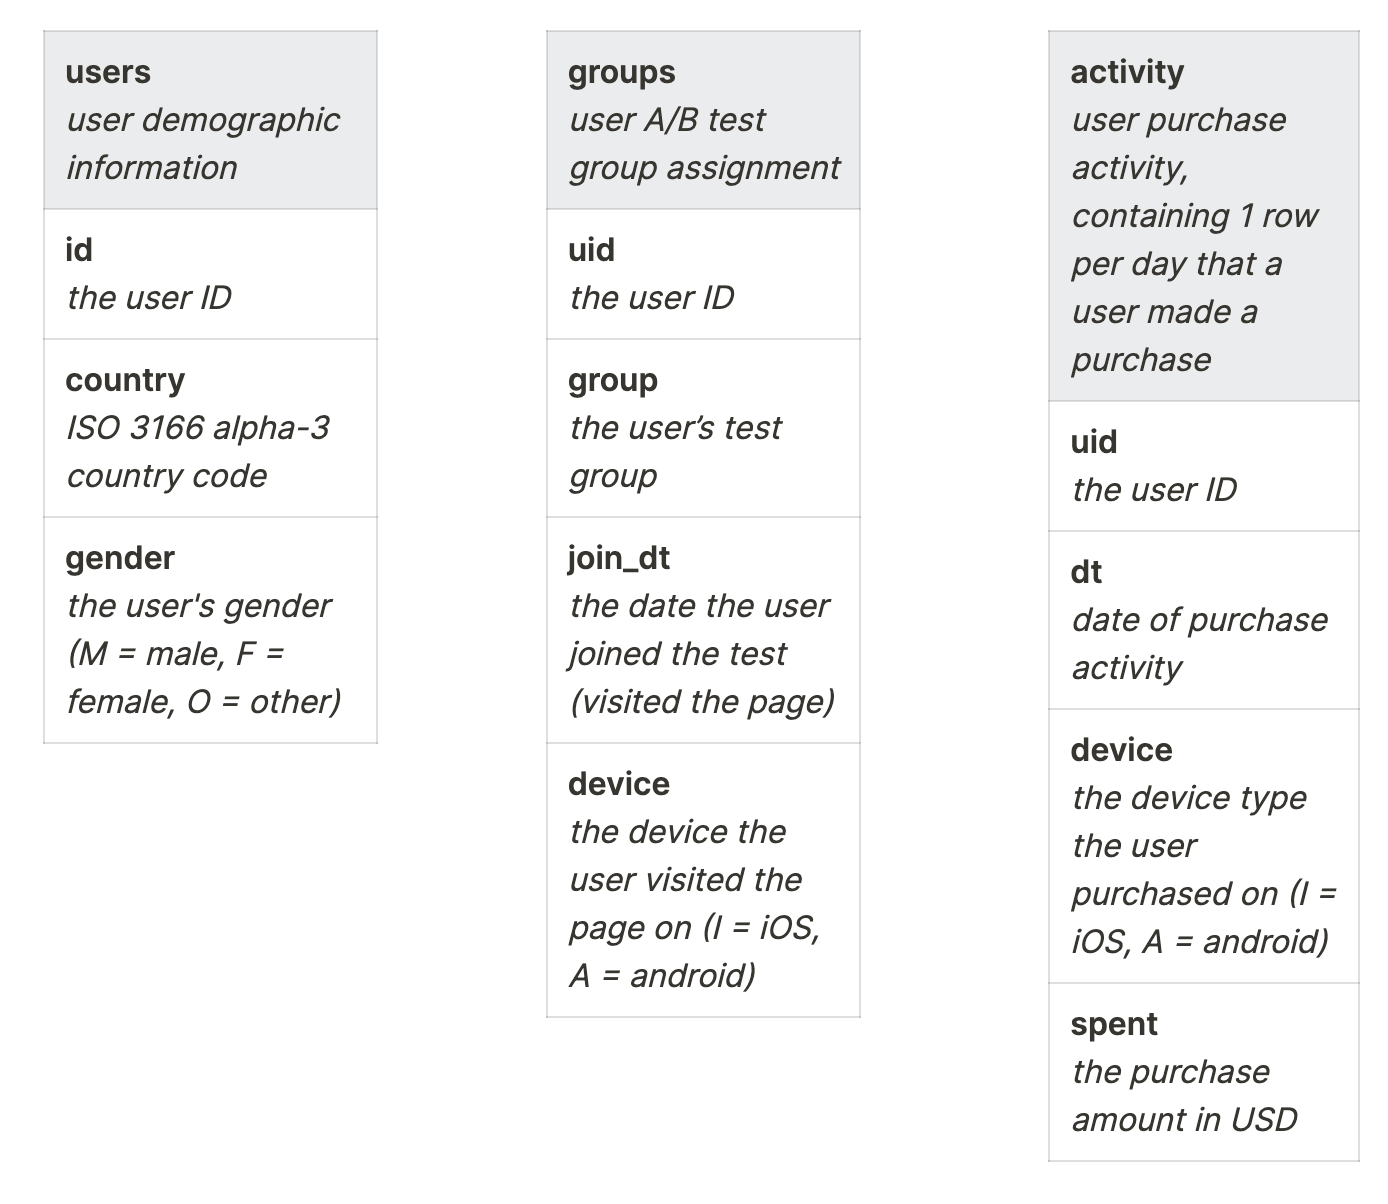


### ETL in PostgreSQL 
Join the three tables and extract only the necessary columns using the query below. The dataset is stored in bi.io database and therefore could be downloaded as a .csv document directly from the database. 

[Link to database](https://bit.io/griffinmasterschool/ab_test_project)

**Notes:** This project does not focus on exploratory analysis or data-wrangling, see below the short explanation of the data preparation: 
* Every user was assigned a group, but not every user made an action. Therefore, a left join was used to preserve all users in the resulting table, even if they didn't have any corresponding rows in the activity table.
* Since users with no amount spent would have a null value in the total_spent_per_user column, the COALESCE function was used to replace null values with 0 spent.
* The resulting table was grouped by the id and group columns to aggregate the total amount spent by each user in each group. Users who spent multiple times were represented by a single row with their total expenditure.
* Finally, the resulting table was aggregated to the user level, resulting in one row per user. 

```sql

SELECT id, g.group, SUM(COALESCE(spent,0)) AS total_spent_per_user
FROM groups g
FULL OUTER JOIN users u
ON g.uid = u.id
LEFT JOIN activity a
ON u.id = a.uid
GROUP BY 1,2

# Experiment Design

1. **Goal** 

The goal of this test is to determine whether the treatment has a statistically and practically significant effect on the average spent per user or conversion rate.

2. **Hypothesis** 

3. **Test Users**

* Control - group A: Users who will see the existing website user interface with no banner.
* Treatment - group B: Users who will see the updated website user interface with banner.

4. **Sample selection** 

Randomly selected users from the website's traffic, excluding any users who have previously participated in an A/B test on the website.

5. **Sample size determination** 

The sample size can be determined by statistical power analysis, which takes into account the expected effect size, the desired level of statistical significance, and the power of the test. The sample size should be large enough to detect meaningful differences in the metrics being measured.

6. **Test duration** 

The test should be run for a sufficient period to collect enough data to determine if the treatment group's Average spent per user and Conversion rate differ significantly from the control group. The duration will depend on the website's traffic and the expected effect size.

7. **Metrics** 

Average spent per user (Mean) and Conversion rate (Proportion).

8. **Statistical method** 

A two-tailed t-test can be used to compare the mean Average spent per user and a z-test to compare the Conversion rate of the control and treatment groups. The test should be performed with a pre-defined level of significance, e.g., alpha = 0.05.

9. **Expected outcome** 

If the treatment group shows a statistically significant increase in either **Average spent per user** or **Conversion rate** compared to the control group, the banner can be implemented on the website. If there is no significant difference or a negative effect, the existing user interface should be maintained.

# Python Functions 

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import t
from scipy.stats import ttest_ind
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [30]:
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'serif'

In [2]:
def get_mean_and_se(df, col):
    '''
    Compute the mean and standard error of a column in a pandas DataFrame.

    Parameters
    ----------
    df : pandas DataFrame
        The DataFrame containing the column to compute the mean and standard error for.
    col : str
        The name of the column to compute the mean and standard error for.

    Returns
    -------
    mean,se: tuple
        A tuple containing two values: the mean of the specified column, and the standard error of the mean.
    '''
    mean = df[col].mean()
    se = df[col].std() / np.sqrt(len(df))
    return mean, se


In [3]:
def critical_value(sig, dof, test_kind='two-tail'):
    '''
    Calculate critical value for various tests.

    Parameters:
    -----------
    sig: float
        Significance level between 0 and 1 e.g. 0.05
    dof: int
        Degrees of freedom i.e. number of data points - 1
    test_kind: string
        Type of test i.e. left, right, two-tail. 
        Default is two-tail. 

    Returns: 
    --------
    critical_value: float 
        The critical value.
    '''
    
    from scipy.stats import t
    if test_kind == 'left':
        crit = t.ppf(q=sig, df=dof)
    elif test_kind == 'right':
        crit = t.ppf(q=1-sig, df=dof)
    else:
        crit = t.ppf(q=1-sig/2, df=dof)
    return crit

In [4]:
def confidence_interval(mean, se, critical_value):
    '''
    Compute a confidence interval for a given mean and standard error.

    Parameters
    ----------
    mean : float
        The sample mean to compute the confidence interval for.
    se : float
        The standard error of the mean.
    critical_value : float
        The critical value for the desired confidence level.

    Returns
    -------
    tuple
        A tuple containing the lower and upper bounds of the confidence interval.
    '''

    lower = mean - critical_value * se
    upper = mean + critical_value * se
    return lower, upper 

In [5]:
def t_test_statistic_1_samp (sample, sample_col, hypothesis_mean):
    '''
    Calculates a t-test for one sample.
       T = (x̄ - μ₀) / (s / √n)
     
    Parameters:
    -----------
    sample: df
        This is you sample dataframe.
    sample_col: string
        This is the column to be aggregated. 
    hypothesis_mean: float
        μ₀: This is the hypothesized population mean, which is the value you want to test against.
    
    Returns:
    --------
    T: float
        This is the calculated t-value, which measures the difference between the sample mean (x̄) 
        and the hypothesized population mean (μ₀) in units of the standard error of the sample mean.
        The resulting t-value is compared to a t-distribution to determine the probability of 
        observing such a large difference between the sample mean and the hypothesized population mean 
        by chance alone. If this probability is low enough (usually set at a significance level of 0.05), 
        we reject the null hypothesis that the sample mean is not significantly different 
        from the hypothesized population mean.
    '''
    sample_n = len(sample)
    mean, se = get_mean_and_se(sample, sample_col)

    t_1_samp = (mean - hypothesis_mean) / se
    return t_1_samp

In [122]:
def t_test_statistic_2_samp (sample_1, sample_2, col_1, col_2, hypothesis_mean=0):
    '''
    Calculates the t-test statistic for two independent samples.

    Parameters:
    -----------
    sample_1 : pandas DataFrame
        The first DataFrame used for computing the mean and standard error.
    sample_2 : pandas DataFrame
        The second DataFrame used for computing the mean and standard error.
    col_1 : str
        The column used for analysis within the first DataFrame.
    col_2 : str
        The column used for analysis within the second DataFrame. 
    hypothesis_mean : float, optional
        The null hypothesis mean, which is the value being tested against the sample means to 
        determine whether the difference between them is statistically significant. The default is 0. 

    Returns:
    --------
    float
        The t-test statistic for two independent samples.
    '''
    mean_1, se_1 = get_mean_and_se(sample_1, col_1)
    mean_2, se_2 = get_mean_and_se(sample_2, col_2)

    t_2_samp = ((mean_2 - mean_1) - hypothesis_mean) / np.sqrt((se_1**2 + se_2**2))
    return t_2_samp


In [7]:
def confidence_interval_diff_mean(control_sample, treamtent_sample, col_1, col_2, sig):
    '''
    Compute a confidence interval for the difference between the means of two samples.

    Parameters
    ----------
    control_sample : pandas DataFrame
        The control sample data containing the column specified by `col_1`.
    treamtent_sample : pandas DataFrame
        The treatment sample data containing the column specified by `col_2`.
    col_1 : str
        The name of the column in `control_sample` to compute the mean and standard error for.
    col_2 : str
        The name of the column in `treatment_sample` to compute the mean and standard error for.
    sig : float
        The desired significance level (e.g., 0.05).

    Returns
    -------
    tuple
        A tuple containing the lower and upper bounds of the confidence interval for the difference between the means of
        the two samples.
    '''
    control_mean, se_1 = get_mean_and_se(control_sample, col_1)
    treatment_mean, se_2 = get_mean_and_se(treamtent_sample, col_2)
    dof = (len(control_sample) - 1) + (len(treamtent_sample) - 1)
    test_kind = 'two-tail'

    sample_stat = treatment_mean - control_mean
    se = np.sqrt(se_1**2 + se_2**2)

    crit_value = critical_value(sig, dof, test_kind='two-tail')

    lower = sample_stat - crit_value * se
    upper = sample_stat + crit_value * se

    return lower, upper


In [8]:
def conversion_rate(df, col):
    '''
    Calculate the conversion rate of a column in a pandas DataFrame.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data.
    col (str): The name of the column to calculate the conversion rate for.

    Returns:
    float: The conversion rate as a percentage, i.e., the proportion of rows
           in the DataFrame where the value in the specified column is non-zero.

    Example:
    >>> data = pd.DataFrame({'col1': [0, 1, 0, 1], 'col2': [1, 0, 1, 0]})
    >>> conversion_rate(data, 'col1')
    0.5
    '''

    con_rate = len(df[df[col] != 0]) / len(df)

    return con_rate

In [9]:
def proportion_stats(df, col):

    '''
    Calculate the sample proportion and standard error for a column in a pandas DataFrame.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data.
    col (str): The name of the column to calculate the sample proportion and standard error for.

    Returns:
    tuple: A tuple containing the sample proportion and standard error as floats.

    Example:
    >>> data = pd.DataFrame({'col1': [0, 1, 0, 1], 'col2': [1, 0, 1, 0]})
    >>> proportion_stats(data, 'col1')
    (0.5, 0.2886751345948129)
    '''

    sample_statistic = len(df[df[col] != 0]) / len(df)
    se = np.sqrt(sample_statistic*(1-sample_statistic)/len(df))
    
    return sample_statistic, se

In [10]:
def critical_value_proportion(sig, test_kind='two-tail'):

    '''Calculate critical value for various tests.

    Parameters:
    -----------
    sig: float
        Significance level between 0 and 1 e.g. 0.05
    test_kind: string
        Type of test i.e. left, right, two-tail. 
        Default is two-tail. 

    Returns: 
    --------
    critical_value: float 
        The critical value for the given significance level and test type.
        
    Example:
    >>> critical_value_proportion(0.05, 'two-tail')
    1.959963984540054
        
    '''
    from scipy.stats import norm
    if test_kind == 'left':
        crit = norm.ppf(q=sig)
    elif test_kind == 'right':
        crit = norm.ppf(q=1-sig)
    else:
        crit = norm.ppf(q=1-sig/2)
    return crit

In [11]:
def pooled_t_statistic_prop(p1 , p2, df1, df2 ):

    '''Computes the pooled t-statistic for two independent samples with known proportions.

    Parameters
    ----------
    p1 : float
        Proportion of successes in sample 1.
    p2 : float
        Proportion of successes in sample 2.
    df1 : array-like
        Sample 1.
    df2 : array-like
        Sample 2.

    Returns
    -------
    pooled_t : float
        The pooled t-statistic.

    Notes
    -----
    The pooled t-statistic is used to test the hypothesis that two independent samples have equal population means. It assumes that the variances of the two populations are equal. The formula for the pooled t-statistic is:
    pooled_t = (p1 - p2) / sqrt(p * (1 - p) * (1 / n1 + 1 / n2))

        where:
            - p is the pooled proportion of successes
            - n1 and n2 are the sample sizes of sample 1 and sample 2, respectively'''


    n1 = len(df1)
    n2 = len(df2)

    p = (p1 * n1 + p2 * n2) / (n1 + n2)

    pooled_t = (p1-p2) / np.sqrt( p*(1-p) * (1/n1 + 1/n2) )

    return pooled_t

In [12]:
def se_unpooled_prop(p1 , p2, df1, df2):
    '''Computes the unpooled standard-error for z-interval for two independent samples with known proportions.

    Parameters
    ----------
    p1 : float
        Proportion of successes in sample 1.
    p2 : float
        Proportion of successes in sample 2.
    df1 : array-like
        Sample 1.
    df2 : array-like
        Sample 2.

    Returns
    -------
    unpooled_se : float
        The unpooled standard-error.'''
    
    n1 = len(df1)
    n2 = len(df2)
    
    unpooled_se = np.sqrt((p1*(1-p1)/n1) + (p2*(1-p2)/n2))

    return unpooled_se

In [13]:
# incomplete

def unpooled_t_statistic_prop(p1 , p2, df1, df2 ):

    '''Computes the unpooled t-statistic for two independent samples with known proportions.

    Parameters
    ----------
    p1 : float
        Proportion of successes in sample 1.
    p2 : float
        Proportion of successes in sample 2.
    df1 : array-like
        Sample 1.
    df2 : array-like
        Sample 2.

    Returns
    -------
    pooled_t : float
        The pooled t-statistic.'''


    n1 = len(df1)
    n2 = len(df2)

    

    return unpooled_t

# Hypothesis Test: Average Spent Per User

### $H_0$: $\mu_{control} = \mu_{treatment}$ 
The average spent between the control and the treatment groups are the same.

### $H_A$: $\mu_{control} \neq \mu_{treatment}$ 
The average spent between the control and the treatment groups are different.

In [14]:
# Data Import

df = pd.read_csv("query_results.csv")

df.head()

,id,group,total_spent_per_user
0,1014313,B,0.0
1,1029532,B,0.0
2,1018168,A,0.0
3,1029599,A,0.0
4,1025920,B,0.0


In [15]:
# Isolate the data for the Control group: A

df_a = df[df["group"]=="A"]

# Isolate the data for the Treatment group: B

df_b = df[df["group"]=="B"]

### Significance Level

The significance level is 0.05 or 5%. This is the level of significance used to determine whether to reject the null hypothesis.

### Confidence Level

The confidence level is 0.95 or 95%. This means that we are 95% confident that the true population mean falls within the computed confidence interval.

> At a significance level of 5%, we reject the null hypothesis if the p-value is less than 0.05. At a confidence level of 95%, we are 95% confident that the true difference in means falls within the calculated confidence interval.

In [16]:
# Set the significance level (alpha) to 5%
# Giving us a confidence level of 95%

sig = 0.05

### Sample statistic (Mean) and Standard Error

In [17]:
# Calculate the mean and standard error of the Control Group: A

mean_a, se_a = get_mean_and_se(df_a, "total_spent_per_user")

# Calculate the mean and standard error of the Control Group: A

mean_b, se_b = get_mean_and_se(df_b, "total_spent_per_user")

# Print means and standard errors

print(f'Mean for Control group: {mean_a:.3f}\nStandard error for Control Group: {se_a:.3f}\nMean for Treatment group: {mean_b:.3f}\nStandard error for Treatment Group: {se_b:.3f}')


Mean for Control group: 3.375
Standard error for Control Group: 0.166
Mean for Treatment group: 3.391
Standard error for Treatment Group: 0.162


### Critical Value

In [18]:
# Calculate the critical value
critical_a = critical_value(sig, dof=len(df_a) - 1)
critical_b = critical_value(sig, dof=len(df_b) - 1)

print(f'Critical value for Control group: {critical_a:.3f}')
print(f'Critical value for Treatment group: {critical_b:.3f}')

Critical value for Control group: 1.960
Critical value for Treatment group: 1.960


### Confidence Intervals

In [19]:

# Calculate the confidence interval for the control
confidence_interval_a = confidence_interval(mean_a, se_a, critical_a)

# Calculate the confidence interval for the treatment
confidence_interval_b = confidence_interval(mean_b, se_b, critical_b)


print('Confidence interval for Control group: {:.4}, {:.4}'.format(*confidence_interval_a))
print('Confidence interval for Treatment group: {:.4}, {:.4}'.format(*confidence_interval_b))

Confidence interval for Control group: 3.049, 3.7
Confidence interval for Treatment group: 3.073, 3.708


In [20]:
df_a['total_spent_per_user'].max()

1659.4

In [21]:
df_a['total_spent_per_user'].min()

0.0

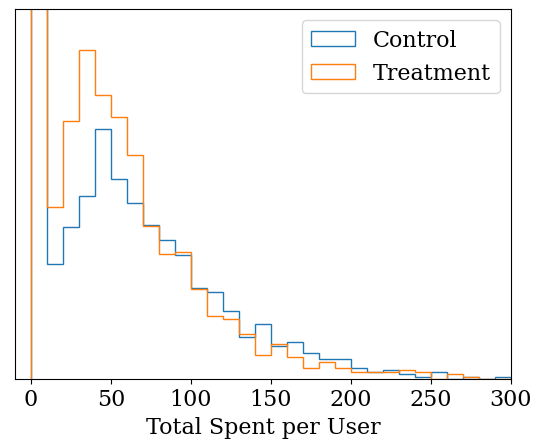

In [47]:
bins = np.linspace(0, 300, 31) 
plt.hist(df_a['total_spent_per_user'], bins=bins, histtype='step', density=True, color='tab:blue', alpha=1, label='Control')
plt.hist(df_b['total_spent_per_user'], bins=bins, histtype='step', density=True, color='tab:orange', alpha=1, label='Treatment')
plt.xlim(-10, 300)
plt.ylim(0, 0.0007)
plt.yticks([], [])
plt.xlabel('Total Spent per User')
plt.legend()


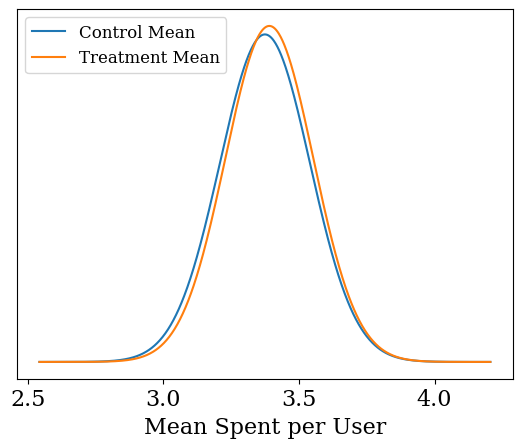

In [53]:
x = np.linspace(mean_a-5*se_a, mean_a+5*se_a, 1001)
y_a = norm.pdf(x, loc=mean_a, scale=se_a)
y_b = norm.pdf(x, loc=mean_b, scale=se_b)

plt.plot(x, y_a, label='Control Mean')
plt.plot(x, y_b, label='Treatment Mean')
plt.yticks([], [])
plt.xlabel('Mean Spent per User')
plt.legend(fontsize=12, loc='upper left')


In [82]:
ci_diff_mean = confidence_interval_diff_mean(df_a, df_b, 'total_spent_per_user', 'total_spent_per_user', sig)

print('Confidence interval for the difference in means: {:.4}, {:.4}'.format(*ci_diff_mean))

Confidence interval for the difference in means: -0.4386, 0.4713


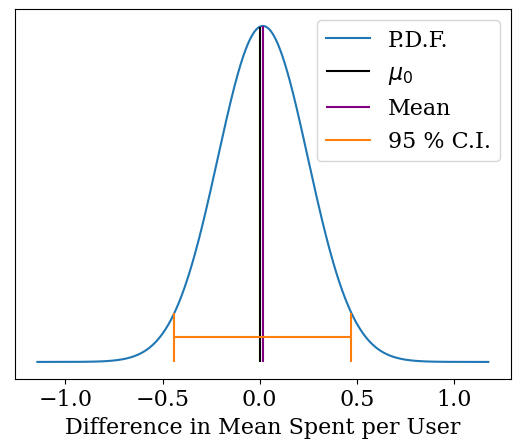

In [124]:
# Calculate mean and std
mean_diff = mean_b - mean_a
se_diff = np.sqrt(se_a**2 + se_b**2)
# Make a pdf function with appropriate mean and std
pdf_diff = lambda x: norm.pdf(x, loc=mean_diff, scale=se_diff)

# Set the range of the plot
x = np.linspace(mean_diff-5*se_diff, mean_diff+5*se_diff, 1001)
# Evaluate the pdf over the range
y = pdf_diff(x)

# Plot the pdf
plt.plot(x, y, label='P.D.F.')
# Plot the null-hypothesis
plt.vlines(0, 0, pdf_diff(0), color='black', label=r'$\mu_0$')
plt.vlines(mean_diff, 0, pdf_diff(mean_diff), color='purple', label=r'Mean')

# Remove the y-ticks
plt.yticks([], [])
# Set the x-axis label
plt.xlabel('Difference in Mean Spent per User')
# Make vertical lines for the confidence interval up to the pdf value
plt.vlines(ci_diff_mean, 0, pdf_diff(ci_diff_mean), color='tab:orange')
# Make the horizontal line for the confiudence interval half way up the vertical line
plt.plot(np.linspace(*ci_diff_mean, 101), pdf_diff(ci_diff_mean[0])*np.ones(101)/2, label=f'{100*(1-sig):.0f} % C.I.')
# Create a legend for the different lines
plt.legend();

### Test-statistic for a two-sample T-test

In [123]:
# Conduct t-test assuming unequal variance

t_stat_2_samp = t_test_statistic_2_samp(df_a, df_b, 'total_spent_per_user', 'total_spent_per_user', 0)

print("test-statistic = ", np.round(t_stat_2_samp,4))


test-statistic =  0.0704


### P-value

In [113]:
# to get two sided p-value
# 2 * (1 - t.cdf(absolute(t-statistic), dof))

p_value = 2*(1-t.cdf(np.abs(t_stat_2_samp), df=np.min([len(df_a)-1, len(df_b)-1])))

print("p-value:", np.round(p_value,4))

p-value: 0.9439


### Conculsion

In [114]:
# Check significance level at 5%
if p_value < sig:
    print("Conclusion: Reject the null hypothesis")
else:
    print("Conclusion: Fail to reject the null hypothesis")

Conclusion: Fail to reject the null hypothesis


### Plotting the T-Distribution for difference in Means

Text(0.5, 1.0, 'T-Distribution for Difference in Means')

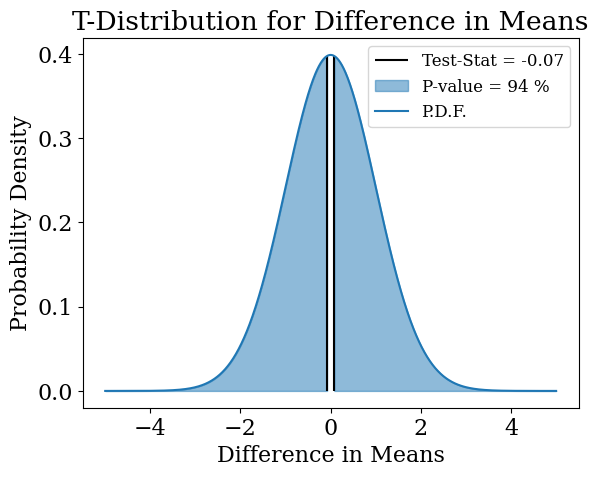

In [119]:
pdf_t = lambda x: stats.t.pdf(x, len(df_a) + len(df_b) - 2)
# Plot the t-distribution
x = np.linspace(-5, 5, 1001)
y = pdf_t(x)

plt.vlines(t_stat_2_samp, 0, pdf_t(t_stat_2_samp), color='black')
plt.vlines(-t_stat_2_samp, 0, pdf_t(-t_stat_2_samp), color='black', label=f'Test-Stat = {t_stat_2_samp:.2f}')

p_value_range = x[x < -np.abs(t_stat_2_samp)]

plt.fill_between(p_value_range, 0, pdf_t(p_value_range), color='tab:blue', alpha=0.5)
plt.fill_between(-p_value_range, 0, pdf_t(-p_value_range), color='tab:blue', alpha=0.5, label=f'P-value = {100*p_value:.0f} %')

plt.plot(x, y, label='P.D.F.')
plt.legend(fontsize=12)


plt.xlabel('Difference in Means')
plt.ylabel('Probability Density')
plt.title('T-Distribution for Difference in Means')

In [106]:
# to get two sided p-value
# 2 * (1 - t.cdf(absolute(t-statistic), dof))

print(2*(1-t.cdf(np.abs(t_stat_2_samp), df=np.min([len(df_a)-1, len(df_b)-1]))))
print(2*(1-t.cdf(np.abs(0.07042490999751674), df=np.min([len(df_a)-1, len(df_b)-1]))))

0.9438560436782142
0.9438560436782018


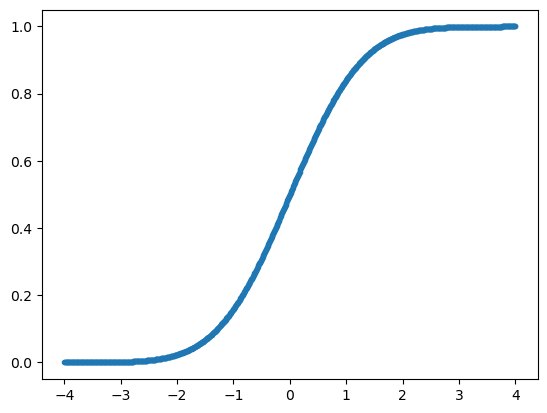

In [107]:
ts = np.linspace(-4, 4, 1000)
cdf = t.cdf(ts, df=200)
plt.plot(ts, cdf, '.')

# Hypothesis Test: Conversion Rate

### $H_0$: $\mu_{control} = \mu_{treatment}$ 
The conversion rate between the control and the treatment groups are the same.

### $H_A$: $\mu_{control} \neq \mu_{treatment}$ 
The conversion rate between the control and the treatment groups are different.

### Significance Level

The significance level is 0.05 or 5%. This is the level of significance used to determine whether to reject the null hypothesis.

### Confidence Level

The confidence level is 0.95 or 95%. This means that we are 95% confident that the true population mean falls within the computed confidence interval.

> At a significance level of 5%, we reject the null hypothesis if the p-value is less than 0.05. At a confidence level of 95%, we are 95% confident that the true difference in means falls within the calculated confidence interval.

### Sample Statistic (Proportion) and Standard Error

The sample statistic in this test refers to the conversion rate.

In [147]:
# calculating the conversion rate and standard errors for control and treatment groups
df_a_sample_stat, df_a_prop_se = proportion_stats(df_a, "total_spent_per_user")
df_b_sample_stat, df_b_prop_se = proportion_stats(df_b, "total_spent_per_user")

# printing the sample stats and standard errors for control groups and treatment groups
print(f'Conversion Rate Control group: {df_a_sample_stat:.4f}) \nStandard Error Control group: {df_a_prop_se:.4f}')
print(f'Conversion Rate Treatment group: {df_b_sample_stat:.4f} \nStandard Error Control group: {df_b_prop_se:.4f}')

Conversion Rate Control group: 0.0392) 
Standard Error Control group: 0.0012
Conversion Rate Treatment group: 0.0463 
Standard Error Control group: 0.0013


In [152]:
# set the significance level to 5%
sig = 0.05

# calculating the critical value for proportions 
critical_val_p = critical_value_proportion(sig)

# print critical value
print(f'Critical value: {critical_val_p:.4f}')

Critical value: 1.9600


### Confidence Intervals

In [154]:
# calculate the confidence interval for the treatment group

df_a_proportion_conf = confidence_interval(df_a_sample_stat, df_a_prop_se, critical_val_p)

print('Confidence Interval for the Treatment group: {:.4f}, {:.4f}'.format(*df_a_proportion_conf))

Confidence Interval for the Treatment group: 0.0368, 0.0417


In [153]:
# calculate the confidence interval for the control group

df_b_proportion_conf = confidence_interval(df_b_sample_stat, df_b_prop_se, critical_val_p)

print('Confidence Interval for the Control group: {:.4f}, {:.4f}'.format(*df_b_proportion_conf))

Confidence Interval for the Control group: 0.0437, 0.0489


Conduct a hypothesis test to see whether there is a difference in the conversion rate between the two groups. What are the resulting p-value and conclusion?
Use the normal distribution and a 5% significance level. Use the pooled proportion for the standard error.

### Pooled Test Statistic

> The pooled proportion is the weighted average of the proportions of the two samples. It is used in the two-proportions z-test with a pooled approach to estimate the population proportion when the population variances of the two samples are assumed to be equal.

In [179]:
# calculate the pooled proportion test statistic for two-sample z-test where variance is equal 

# H0: p1 - p2 = p0

pooled_t_stat = pooled_t_statistic_prop(df_a_sample_stat, df_b_sample_stat, df_a, df_b)

print('Pooled proportion test statistic: {:.3f}'.format(pooled_t_stat))

Pooled proportion test statistic: -3.864


In [157]:
p_val_proportion = 2*(1-norm.cdf(np.abs(pooled_t_stat),))

print('Proportion P-value: {:.6f}'.format(p_val_proportion))

Proportion P-value: 0.000111


### Confidence interval 

For the difference in the conversion rate between the treatment and control (treatment-control) 
using the normal distribution and unpooled proportions for the standard error.

In [120]:
diff_prop_se = se_unpooled_prop(df_a_sample_stat , df_b_sample_stat, df_a, df_b)

diff_prop_se

0.0018284884033368863

In [121]:
diff_prop_conf = confidence_interval((df_b_sample_stat - df_a_sample_stat), diff_prop_se, critical_df_a)

diff_prop_conf

(0.0034860511629807105, 0.0106535939963596)